### 1. Imports

In [ ]:
import os, re, json, random, numpy as np, pandas as pd, torch
from typing import Dict, List, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import evaluate
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import Dataset, DatasetDict

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "distilbert-base-uncased"

# Integers -> human-readable names (edit if your int mapping differs!)
CLASS_NAMES = [
    "No PII",
    "name",
    "email",
    "phone number",
    "SSN",
    "address",
    "login credentials",
]
NUM_LABELS = len(CLASS_NAMES)
ID2LABEL = {i: cls for i, cls in enumerate(CLASS_NAMES)}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

print(f"Using device: {device}")
print("Classes:", ID2LABEL)

Using device: cuda
Classes: {0: 'No PII', 1: 'Has PII'}


### 2. Load dataset

In [ ]:
CSV_PATH = "data/dataset_large.csv"

df = pd.read_csv(CSV_PATH)
assert {"text", "label"}.issubset(
    df.columns
), "CSV must contain 'text' and 'label' columns."
df = df.dropna(subset=["text", "label"]).copy()

# Ensure integer dtype
df["label_id"] = df["label"].astype(int)

# Validate label range
min_lbl, max_lbl = df["label_id"].min(), df["label_id"].max()
assert (
    min_lbl >= 0 and max_lbl < NUM_LABELS
), f"Labels must be in [0,{NUM_LABELS-1}], got [{min_lbl},{max_lbl}]"

# Split (stratify on label_id)
df_train, df_temp = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label_id"]
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=SEED, stratify=df_temp["label_id"]
)

print("Train/Val/Test shapes:", df_train.shape, df_val.shape, df_test.shape)
print("Train class counts:\n", df_train["label_id"].value_counts().sort_index())
df_train.head()

Counts (binary):
label_bin
0    52387
1     3823
Name: count, dtype: int64
Train shape: (44968, 4) Val: (5621, 4) Test: (5621, 4)


,text,label,label_id,label_bin
23804,RE: yauth smok ng cassation,0,0,0
53701,(W-PM),0,0,0
27830,identify,0,0,0
28231,for,0,0,0
12719,Ecb,0,0,0


### 3. Tokenise Dataset

In [ ]:
# Tokenisation
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128


def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )


ds_train = Dataset.from_pandas(df_train[["text", "label_id"]].reset_index(drop=True))
ds_val = Dataset.from_pandas(df_val[["text", "label_id"]].reset_index(drop=True))
ds_test = Dataset.from_pandas(df_test[["text", "label_id"]].reset_index(drop=True))

dataset = DatasetDict({"train": ds_train, "validation": ds_val, "test": ds_test})
dataset = dataset.map(tokenize_batch, batched=True)

# Set columns Trainer expects
# after tokenization:
print(dataset.column_names)
dataset = dataset.rename_column("label_id", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 5621/5621 [00:00<00:00, 14017.26 examples/s]


### 4. Class weights to counter dataset imbalance

In [ ]:
class_counts = df_train["label_id"].value_counts().sort_index()
class_weights = (class_counts.sum() / (len(class_counts) * class_counts)).values
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class_counts, class_weights

Class counts: {0: 41910, 1: 3058}
Weights: [0.5364829301834106, 7.352518081665039]


### 5. Initialize model

In [ ]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, config=config
).to(device)

from torch.nn import CrossEntropyLoss


def custom_compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(
        input_ids=inputs.get("input_ids"), attention_mask=inputs.get("attention_mask")
    )
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 6. Set up eval metrics

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro}

### 7. Training arguments and trainer class

In [ ]:
OUTPUT_DIR = "distilbert-pii"

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=100,
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
    seed=SEED,
)

In [ ]:
from torch.nn import CrossEntropyLoss
from transformers import Trainer


def custom_compute_loss(model, inputs, class_weights, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(
        input_ids=inputs.get("input_ids"),
        attention_mask=inputs.get("attention_mask"),
    )
    logits = outputs.get("logits")
    loss_fct = CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss


class WeightedLossTrainer(Trainer):
    # Accept any future kwargs to avoid breaking when HF adds new args
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        return custom_compute_loss(
            model, inputs, class_weights, return_outputs=return_outputs
        )

### 8. Model training

In [86]:
trainer = WeightedLossTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

C:\Users\GX\AppData\Local\Temp\ipykernel_31720\3750518865.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,0.773600,0.677270,0.929906,0.709171
400,0.582900,0.612748,0.926348,0.733671
600,0.584600,0.553575,0.916029,0.725497
800,0.668600,0.600761,0.920655,0.735480
1000,0.580000,0.460943,0.910514,0.729543
1200,0.527100,0.568083,0.931507,0.750964
1400,0.569400,0.781693,0.936132,0.749441
1600,0.487200,0.816437,0.936132,0.737369
1800,0.558300,0.569684,0.931863,0.743764


TrainOutput(global_step=1800, training_loss=0.5861889055040148, metrics={'train_runtime': 159.2062, 'train_samples_per_second': 1129.805, 'train_steps_per_second': 70.625, 'total_flos': 953765270323200.0, 'train_loss': 0.5861889055040148, 'epoch': 0.6403415154749199})

### 9. Model evaluation

{'test_loss': 0.533394455909729, 'test_accuracy': 0.9295499021526419, 'test_f1_macro': 0.7401221682054444, 'test_runtime': 4.7351, 'test_samples_per_second': 1187.101, 'test_steps_per_second': 37.169}
              precision    recall  f1-score   support

      No PII       0.97      0.96      0.96      5239
     Has PII       0.48      0.56      0.52       382

    accuracy                           0.93      5621
   macro avg       0.73      0.76      0.74      5621
weighted avg       0.93      0.93      0.93      5621



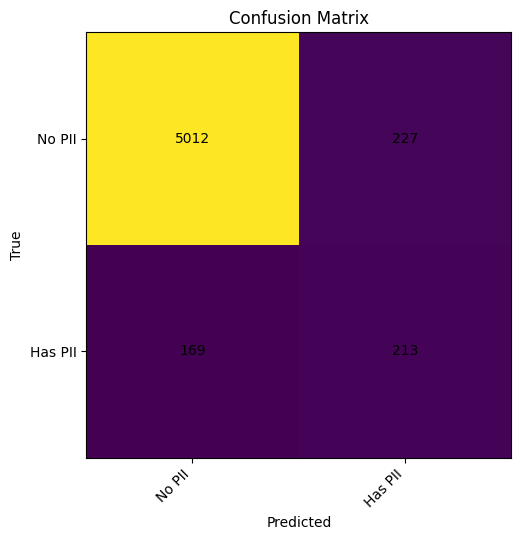

In [ ]:
test_out = trainer.predict(dataset["test"])
print(test_out.metrics)

y_true = test_out.label_ids
y_pred = np.argmax(test_out.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABEL2ID))))
fig, ax = plt.subplots(figsize=(6, 5.5))
im = ax.imshow(cm)
ax.set_xticks(range(len(LABEL2ID)))
ax.set_xticklabels([ID2LABEL[i] for i in range(len(LABEL2ID))], rotation=45, ha="right")
ax.set_yticks(range(len(LABEL2ID)))
ax.set_yticklabels([ID2LABEL[i] for i in range(len(LABEL2ID))])
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.show()

### 10. Saving the trained model

In [ ]:
trainer.save_model(OUTPUT_DIR)
with open(os.path.join(OUTPUT_DIR, "label2id.json"), "w") as f:
    json.dump(LABEL2ID, f)  # names->ids for pretty output